In [ ]:
! yes | . ./setup.sh;

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import pickle5 as pickle
import seaborn as sns
import time
import datetime
from neurals.nn import DataSynthesizer
from neurals.transformer import DataTransformer
        
import warnings
warnings.filterwarnings("ignore")

In [93]:
%%time
ADD_GEO_MAP = pickle.load(open('models/add_to_geo_map.pkl', 'rb'))
FOREX = pickle.load(open("models/exchange_rates.pkl", "rb"))

CPU times: user 947 µs, sys: 7.95 ms, total: 8.9 ms
Wall time: 8.18 ms


In [145]:
from bisect import bisect_left
from geopy.distance import geodesic
from collections import OrderedDict
from operator import getitem
import numpy as np


def geo_loc(point = None, address = None):
    
    from geopy.geocoders import Nominatim
    geolocator = Nominatim(user_agent="map.app")
    
    if address is None:
        try:
            location = geolocator.reverse(point)
            return (location.address, (location.latitude, location.longitude), 
                    location.raw)
        except:
            return 'Invalid geo-coordinates !!'
    else:
        try:
            location = geolocator.geocode(address)
            return (location.address, (location.latitude, location.longitude), 
                    location.raw)
        except:
            return 'Invalid Address !!'

def get_lat_long(address):
    try:
        point_ = ADD_GEO_MAP[address.strip()]
        return point_['latitude'], point_['longitude']
    except:
        point_ = geo_loc(address = address.strip())
        return point_[2]['lat'], point_[2]['lon']
    else:
        return 0, 0
    

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

def get_octa(point):
    if float(point['latitude']) < 0:
        if float(point['longitude']) < 0:
            return int(float(point['longitude']) / -90)
        else:
            return int(float(point['longitude']) / 90) + 2
    else:
        if float(point['longitude']) < 0:
            return int(float(point['longitude']) / -90) + 4
        else:
            return int(float(point['longitude']) / 90) + 6


def reorganize_geocodes(geocodes_dictionary):
    from collections import OrderedDict
    coordinates = OrderedDict()
    
    coordinates['address'] = np.array(list(geocodes_dictionary.keys()))
    coordinates['latitude'] = np.array([row['latitude'] for name, row in geocodes_dictionary.items()])
    coordinates['longitude'] = np.array([row['longitude'] for name, row in geocodes_dictionary.items()])
    coordinates['category'] = np.array([row['category'] for name, row in geocodes_dictionary.items()])
    coordinates['distance'] = np.array([row['distance'] for name, row in geocodes_dictionary.items()])
    return coordinates

def augment_geocode_dict(geocodes):
    
    from geopy.distance import geodesic
    from collections import OrderedDict
    from operator import getitem
    
    for key in geocodes.keys():
        geocodes[key]['category'] = get_octa(geocodes[key])
        geocodes[key]['distance'] = float(geodesic((0, 0), (geocodes[key]['latitude'], geocodes[key]['longitude'])).km)
    geocodes = OrderedDict(sorted(geocodes.items(), key=lambda x: getitem(x[1], 'distance')))
    return geocodes


def get_nearest_loc(point, geocodes = None):
    from geopy.distance import geodesic
    if geocodes is None:
        return geo_loc(point)
    else:
        try:
            point_category = get_octa(point)
            geolist = geocodes['distance'][geocodes['category'] == point_category]
            distance = float(geodesic((0, 0), (point['latitude'], point['longitude'])).km)
            closest = np.where(geocodes['distance'] == take_closest(geolist, distance))

            closest_category = geocodes['category'][closest][0]
            closest_distance = geocodes['distance'][closest][0]
            # print(closest_category, point_category, abs(closest_distance - distance))
            if (closest_category != point_category) or abs(closest_distance - distance) > 10:
                return geo_loc(point)
            else:
                # return point_category, closest_category, distance, closest_distance, geocodes['address'][closest[0][0]]
                return geocodes['address'][closest[0][0]]

        except:
            return ''

def get_geocodes(address):
    try:
        # return coords_dict[address]
        location = COORDS[address]
        return [location['latitude'], location['longitude']]
    except:
        return ''

In [146]:
%%time
COORDS = reorganize_geocodes(augment_geocode_dict(ADD_GEO_MAP))

CPU times: user 2.47 s, sys: 0 ns, total: 2.47 s
Wall time: 2.46 s


In [94]:
%%time
df = pd.read_csv('data/hackathon_parsed_format_a.csv')

CPU times: user 1.46 s, sys: 80 ms, total: 1.54 s
Wall time: 1.54 s


In [95]:
df

,32a_val_dt,33b_cur,33b_orig_ord_amt,50a_payor_lon,50a_payor_lat,50f_payor_acct_nm:,50f_payor_name:,50f_payor_add_ln_1,50f_payor_add_ln_2,50f_payor_add_lat,...,50k_payor_add_lon,59f_ben_acct_num:,59f_ben_name,59f_ben_add_ln_1,59f_ben_add_ln_2,59f_ben_add_lat,59f_ben_add_lon,71A_chg_dtls,71f_chg_dtls_cur,71f_chg_dtls_amt
0,2021-08-13,RUB,1544103.68,/0000000000000000000000000000009621,BIC68DF2C94,NaN,NaN,NaN,NaN,NaN,...,NaN,6099,ANGEL JAMES,1789 PHILLIPS RD,US GLENDALE,34.146942,-118.247847,SHA,NaN,NaN
1,2021-08-13,RUB,912070.95,/0000000000000000000000000000007346,BIC68DF2C94,NaN,NaN,NaN,NaN,NaN,...,NaN,874,JAKUB EVANS,369653 PEAR ST,US WELLS,47.566422,-99.650882,BEN,RUB,0.0
2,2021-08-13,RUB,21760302.59,/0000000000000000000000000000005305,BIC68DF2C94,NaN,NaN,NaN,NaN,NaN,...,NaN,5436,ZIGA MITCHELL,131041 DEBRA DR,US GROVER,42.795605,-110.929451,SHA,NaN,NaN
3,2021-08-13,RUB,878587.53,/0000000000000000000000000000004127,BIC68DF2C94,NaN,NaN,NaN,NaN,NaN,...,NaN,8707,YAEL DEMERS,50438 HAYMARKET ST,US MOORE,35.815612,-101.910435,SHA,NaN,NaN
4,2021-08-13,RUB,6696355.97,/0000000000000000000000000000006978,BIC68DF2C94,NaN,NaN,NaN,NaN,NaN,...,NaN,4326,NOEL PLANTE,43790 MOSHER CT,US WAUCHULA,27.547259,-81.811471,SHA,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379521,2021-08-13,USD,8339.00,/0000000000000000000000000000003030,BIC6A94AE24,NaN,NaN,NaN,NaN,NaN,...,NaN,3627,JESSE LEFEBVRE,147085 CAPITOL AVE,US SOUTH SAN FRANCISCO,37.653540,-122.416866,SHA,NaN,NaN
379522,2021-08-13,USD,4001.56,NaN,NaN,DRLC US VA 0000008040,EMILIJA MITCHELL,345256 YELLOW BRICK RD,US LINCOLN,40.808886,...,NaN,9377,SULTAN OZTURK,120952 PONDEROSA DR,US WARETOWN,39.793896,-74.223206,BEN,USD,0.0
379523,2021-08-13,USD,4456.00,NaN,NaN,DRLC US VA 0000009910,JOO-WON GARCIA,521469 LAKE POINTE AVE,US MIFFLIN,37.941215,...,NaN,1708,DIMITRIOS PASCUAL,134541 E NORTHGATE CT,US COMMERCE CITY,39.808320,-104.933868,OUR,NaN,NaN
379524,2021-08-13,USD,8836.10,/0000000000000000000000000000007977,BIC6A94AE24,NaN,NaN,NaN,NaN,NaN,...,NaN,5070,ADAMA YILDIZ,55827 PRESERVATION WAY,US ESTES PARK,40.366432,-105.502855,SHA,NaN,NaN


In [96]:
data = pd.DataFrame()

In [97]:
# data = df[['33b_cur', '33b_orig_ord_amt']]
data['33b_cur'] = df['33b_cur']

##### Convert all amounts to USD

In [98]:
%%time
print(datetime.datetime.now())
data['usd_amt'] = df[['33b_orig_ord_amt', '33b_cur']].apply(lambda x: x[0] * FOREX[x[1]], axis = 1)
df['usd_amt'] = df[['33b_orig_ord_amt', '33b_cur']].apply(lambda x: x[0] * FOREX[x[1]], axis = 1)

2021-09-22 06:50:39.068021
CPU times: user 5.68 s, sys: 60 ms, total: 5.74 s
Wall time: 5.74 s


In [99]:
%%time
print(datetime.datetime.now())
conditions = [
    ~df['50a_payor_lon'].isnull(), 
    ~df['50f_payor_add_ln_2'].isnull(), 
    ~df['50k_payor_add_ln_2'].isnull()]
choices = ['A', 'F', 'K']
data['src_xfrr_type'] = np.select(conditions, choices, default = "")
df['src_xfrr_type'] = np.select(conditions, choices, default = "")

2021-09-22 06:50:44.815088
CPU times: user 62.2 ms, sys: 0 ns, total: 62.2 ms
Wall time: 61.4 ms


In [100]:
%%time
print(datetime.datetime.now())
conditions = [
    ~df['50f_payor_add_lon'].isnull(),
    ~df["50k_payor_add_lon"].isnull()]
choices = [df["50f_payor_add_lon"], df["50k_payor_add_lon"]]
data['src_lon'] = np.select(conditions, choices, default=0)
df['src_lon'] = np.select(conditions, choices, default=0)

2021-09-22 06:50:44.881393
CPU times: user 13.2 ms, sys: 7 µs, total: 13.2 ms
Wall time: 12.4 ms


In [101]:
%%time
print(datetime.datetime.now())
conditions = [
    ~df["50f_payor_add_lat"].isnull(),
    ~df["50k_payor_add_lat"].isnull()]
choices = [df["50f_payor_add_lat"], df["50k_payor_add_lat"]]
data["src_lat"] = np.select(conditions, choices, default=0)
df["src_lat"] = np.select(conditions, choices, default=0)

2021-09-22 06:50:44.899110
CPU times: user 12.8 ms, sys: 0 ns, total: 12.8 ms
Wall time: 12.1 ms


In [102]:
print(datetime.datetime.now())
data[["target_lat", "target_lon"]] = df.loc[:, ["59f_ben_add_lat", "59f_ben_add_lon"]]
df[["target_lat", "target_lon"]] = df.loc[:, ["59f_ben_add_lat", "59f_ben_add_lon"]]

2021-09-22 06:50:44.915797


In [103]:
print(datetime.datetime.now())
data["charge_dtls"] = df.loc[:, "71A_chg_dtls"]
df["charge_dtls"] = df.loc[:, "71A_chg_dtls"]

2021-09-22 06:50:45.086055


In [104]:
print(datetime.datetime.now())
data[["charge_dtls_cur", "charge_dtls_amt"]] = df.loc[:, ["71f_chg_dtls_cur", "71f_chg_dtls_amt"]]
df[["charge_dtls_cur", "charge_dtls_amt"]] = df.loc[:, ["71f_chg_dtls_cur", "71f_chg_dtls_amt"]]

2021-09-22 06:50:45.092931


In [105]:
%%time
print(datetime.datetime.now())
df.to_csv('data/source_data_for_analysis_v1.csv', index=False)

2021-09-22 06:50:45.275987
CPU times: user 7.23 s, sys: 96 ms, total: 7.33 s
Wall time: 7.59 s


In [106]:
%%time
print(datetime.datetime.now())

data["charge_dtls_cur"] = data["charge_dtls_cur"].replace(np.nan, "999", regex=True)
data["charge_dtls_amt"] = data["charge_dtls_amt"].replace(np.nan, 0, regex=True)

data["target_lat"] = data["target_lat"].replace(np.nan, 0, regex=True)
data["target_lon"] = data["target_lon"].replace(np.nan, 0, regex=True)
data["src_lon"] = data["src_lon"].replace(np.nan, 0, regex=True)
data["src_lat"] = data["src_lat"].replace(np.nan, 0, regex=True)

2021-09-22 06:50:52.874248
CPU times: user 29.9 ms, sys: 0 ns, total: 29.9 ms
Wall time: 29 ms


In [113]:
def get_input_data(neg_cond = None):
    if neg_cond is None:
        input_data = data[data['src_xfrr_type'] == 'A']
        sfx = '_a'
    else:
        input_data = data[data['src_xfrr_type'] != 'A']
        sfx = '_fk'
    return input_data, sfx

In [107]:
%%time
print(datetime.datetime.now())
discrete = [col for col in input_data.columns if col not in data._get_numeric_data().columns]

2021-09-22 06:50:52.907830
CPU times: user 2.03 ms, sys: 4 µs, total: 2.04 ms
Wall time: 1.28 ms


In [134]:
%%time
input_data, sfx = get_input_data(neg_cond = 'A')
xfm_datafile = f"data/xfm_datafile{sfx}.csv"
xfm_model = f"models/gan_transformer{sfx}.pkl"
gan_model = f"models/gan_model{sfx}.pkl"
reload_data = True

CPU times: user 32.2 ms, sys: 8 µs, total: 32.2 ms
Wall time: 31.6 ms


In [119]:
%%time
print(datetime.datetime.now())

if reload_data:
    transformer = DataTransformer()
    transformer.fit(input_data, discrete)
    data_ = transformer.transform(input_data)
    pd.DataFrame(data_).to_csv(xfm_datafile, index=False)
    pickle.dump(transformer, open(xfm_model, 'wb'))
else:
    data_ = pd.read_csv(xfm_datafile).to_numpy()
    transformer = pickle.load(open(xfm_model, 'rb'))

2021-09-22 06:56:39.641438
CPU times: user 8min 19s, sys: 8min 16s, total: 16min 36s
Wall time: 6min 32s


In [120]:
print(datetime.datetime.now())
synthesizer = DataSynthesizer(epochs = 10, verbose = True, pac = 1, 
                              option = 'cnn', num_filters = [10, 10, 10, 10, 10], 
                              filter_sizes = [2, 3, 4, 5, 6],
                              xfm_indicator = True, transformer = transformer, 
                              xfm_datafile = xfm_datafile)

2021-09-22 07:03:16.775094
Initializing synthesizer !!
[[SpanInfo(dim=33, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=4, activation_fn='softmax')], [SpanInfo(dim=2, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=10, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=7, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=7, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=9, activation_fn='softmax')], [SpanInfo(dim=3, activation_fn='softmax')], [SpanInfo(dim=33, activation_fn='softmax')], [SpanInfo(dim=1, activation_fn='tanh'), SpanInfo(dim=1, activation_fn='softmax')]]


In [125]:
%%time
print(datetime.datetime.now())
synthesizer.fit(data, discrete)

2021-09-22 07:04:55.837553
Tranformer indicator is True
Loading data from data/xfm_datafile_fk.csv
Instantiating discriminator with cnn layer as first set of layers !
[2, 3, 4, 5, 6]
DiscriminatorC(
  (conv1d_list): ModuleList(
    (0): Conv1d(71, 10, kernel_size=(2,), stride=(1,))
    (1): Conv1d(71, 10, kernel_size=(3,), stride=(1,))
    (2): Conv1d(71, 10, kernel_size=(4,), stride=(1,))
    (3): Conv1d(71, 10, kernel_size=(5,), stride=(1,))
    (4): Conv1d(71, 10, kernel_size=(6,), stride=(1,))
  )
  (seq): Sequential(
    (0): Linear(in_features=500, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)
Starting training epochs. Number of epochs : 10
Epoch 1, Loss G:  1.0856,Loss D: -1.6575 Elasped Time: 113.66022150200024
Epoc

In [135]:
pickle.dump(gan_model, open(gan_model, 'wb'))

In [160]:
num_samples = 150000

In [161]:
%%time
print(datetime.datetime.now())
samples = synthesizer.sample(num_samples)

2021-09-22 08:34:06.348047
CPU times: user 31.9 s, sys: 204 ms, total: 32.1 s
Wall time: 10.9 s


In [162]:
import concurrent
from functools import partial

# simple wrapper code around serial_calc to parallelize the work
def parallel_calc(df, func, n_core, col):
    futs = []
    df_split = np.array_split(df, n_core)
    # pool = concurrent.futures.ThreadPoolExecutor(max_workers = n_core)
    pool = concurrent.futures.ProcessPoolExecutor(max_workers = n_core)
    apply_partial = partial(func, col=col)
    return pd.concat(pool.map(apply_partial, df_split))

In [163]:
%%time

##------------------------------------------------------------------

def _50f_payor_add_ln_2(row, col):
    return get_nearest_loc({'latitude' : row[col][1], 'longitude': row[col][2]}, geocodes = COORDS) if row[col][0] == 'F' else ''

def proc_50f_payor_add_ln_2(df, col):
    apply_partial = partial(_50f_payor_add_ln_2, col=col)
    # df['50f_payor_add_ln_2'] = df.apply(apply_partial, axis=1)
    # return df
    return df.apply(apply_partial, axis=1)

##------------------------------------------------------------------

def _50k_payor_add_ln_2(row, col):
    return get_nearest_loc({'latitude' : row[col][1], 'longitude': row[col][2]}, geocodes = COORDS) if row[col][0] == 'K' else ''

def proc_50k_payor_add_ln_2(df, col):
    apply_partial = partial(_50k_payor_add_ln_2, col=col)
    # df['50k_payor_add_ln_2'] = df.apply(apply_partial, axis=1)
    # return df
    return df.apply(apply_partial, axis=1)

##------------------------------------------------------------------

def _59f_ben_add_ln_2(row, col):
    return get_nearest_loc({'latitude' : row[col][1], 'longitude': row[col][2]}, geocodes = COORDS)

def proc_59f_ben_add_ln_2(df, col):
    apply_partial = partial(_59f_ben_add_ln_2, col=col)
    # df['59f_ben_add_ln_2'] = df.apply(apply_partial, axis=1)
    # return df
    return df.apply(apply_partial, axis=1)


CPU times: user 18 µs, sys: 0 ns, total: 18 µs
Wall time: 21.7 µs


In [164]:
%%time
samples['50f_payor_add_ln_2'] = ''
samples.loc[samples['src_xfrr_type'] == 'F', '50f_payor_add_ln_2'] = parallel_calc(samples[samples['src_xfrr_type'] == 'F'], 
                                                                             proc_50f_payor_add_ln_2, 8, 
                                                                             ['src_xfrr_type', 'src_lat', 'src_lon'])

CPU times: user 234 ms, sys: 165 ms, total: 399 ms
Wall time: 27.7 s


In [165]:
%%time
condition = [samples['src_xfrr_type'] == 'F', samples['src_xfrr_type'] != 'F']
choice = [samples['src_lat'], 0]
samples['50f_payor_add_lat'] = np.select(condition, choice, default = 0)
    
condition = [samples['src_xfrr_type'] == 'F']
choice = [samples['src_lon']]
samples['50f_payor_add_lon'] = np.select(condition, choice, default = 0)

condition = [samples['src_xfrr_type'] == 'K']
choice = [samples['src_lat']]
samples['50k_payor_add_lat'] = np.select(condition, choice, default = 0)

condition = [samples['src_xfrr_type'] == 'K']
choice = [samples['src_lon']]
samples['50k_payor_add_lon'] = np.select(condition, choice, default = 0)

CPU times: user 51.5 ms, sys: 180 µs, total: 51.7 ms
Wall time: 49.9 ms


In [166]:
%%time
samples['50k_payor_add_ln_2'] = ''
samples.loc[samples['src_xfrr_type'] == 'K', '50k_payor_add_ln_2'] = parallel_calc(samples[samples['src_xfrr_type'] == 'K'], 
                                                                        proc_50k_payor_add_ln_2, 8, 
                                                                        ['src_xfrr_type', 'src_lat', 'src_lon'])

CPU times: user 249 ms, sys: 197 ms, total: 446 ms
Wall time: 42.3 s


In [167]:
%%time
samples['59f_ben_add_ln_2'] = parallel_calc(samples, 
                             proc_59f_ben_add_ln_2, 8, 
                             ['src_xfrr_type', 'src_lat', 'src_lon'])

CPU times: user 1.29 s, sys: 256 ms, total: 1.54 s
Wall time: 55.1 s


In [168]:
%%time
samples['59f_ben_add_lat'] = samples['target_lat']
samples['59f_ben_add_lon'] = samples['target_lon']
samples['71A_chg_dtls'] = samples['charge_dtls']
samples['71f_chg_dtls_cur'] = samples['charge_dtls_cur']
samples['71f_chg_dtls_amt'] = samples['charge_dtls_amt']

CPU times: user 5.67 ms, sys: 3.89 ms, total: 9.56 ms
Wall time: 7.89 ms


In [169]:
%%time
print(datetime.datetime.now())
ver = 1
samples_data_file = f"data/samples_gan_for_analysis_{sfx}_{ver}.csv"
samples.to_csv(samples_data_file, index=False)

2021-09-22 08:36:22.476728
CPU times: user 2.96 s, sys: 51.6 ms, total: 3.01 s
Wall time: 3.17 s


In [170]:
def corrplot(data, samples):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    sns.heatmap(data.loc[:, :"target_lat"].corr(), annot=True, cmap="Blues")
    
    plt.subplot(122)
    sns.heatmap(samples.loc[:, :"target_lat"].corr(), annot=True, cmap="Blues")

In [171]:
def attr_plot(data, samples):
    
    numerical_columns = data._get_numeric_data().columns
    discrete_columns = [col for col in data.columns if col not in numerical_columns]
    
    for col in data.columns:
        if col not in discrete_columns:
            plt.figure(figsize=(20, 5))
            plt.subplot(121)
            sns.distplot(data[col], bins=100, hist_kws={'alpha': 0.7})
            plt.subplot(122)
            sns.distplot(samples[col], bins=100, hist_kws={'alpha': 0.7})
        else:
            plt.figure(figsize=(20, 5))
            plt.subplot(121)
            sns.countplot(x=col, data=data)
            plt.xticks(rotation=45)
            plt.subplot(122)
            sns.countplot(x=col, data=samples)
            plt.xticks(rotation=45)

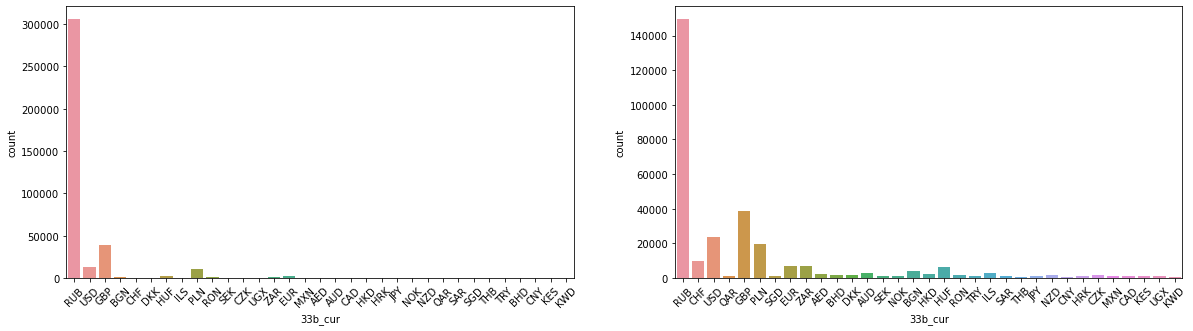

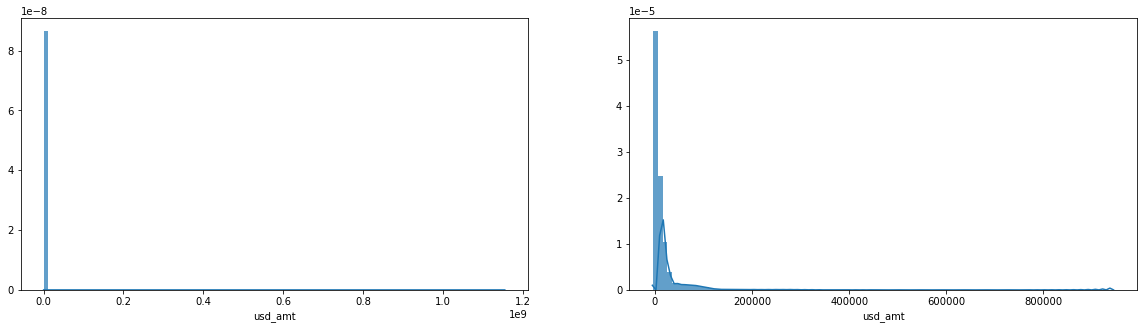

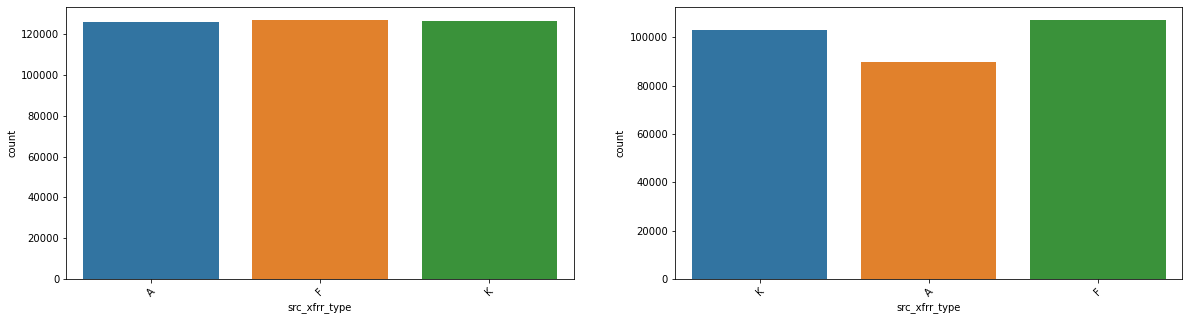

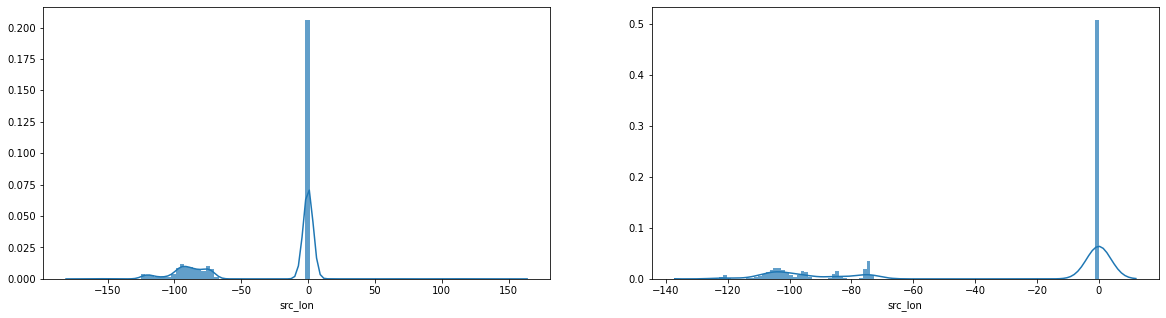

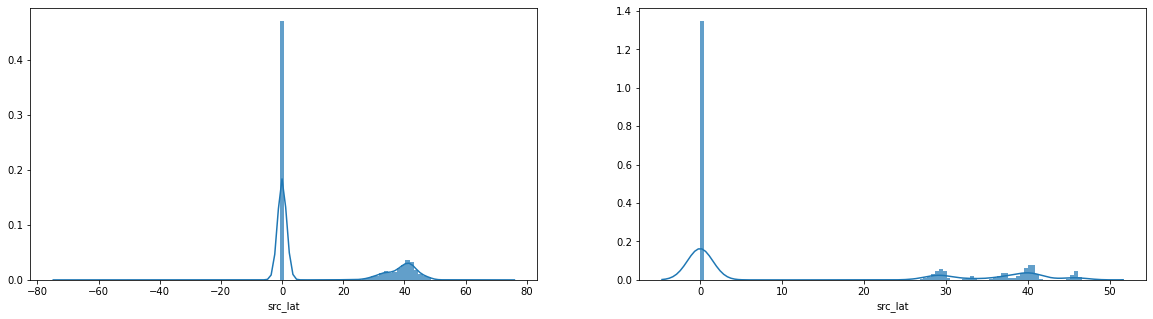

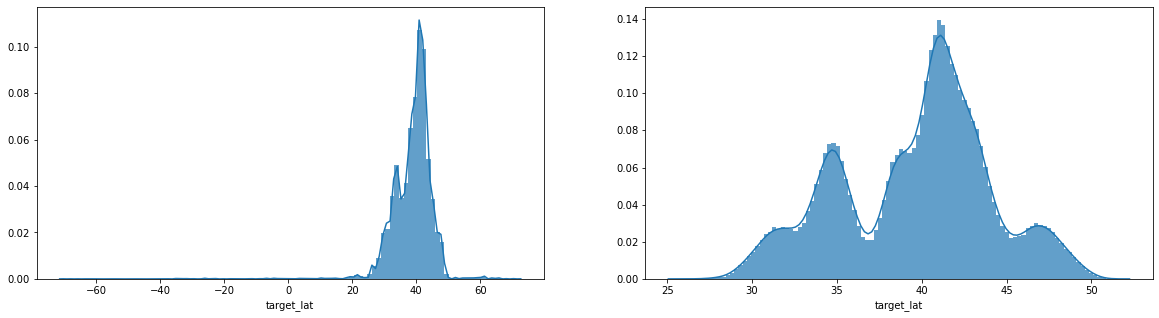

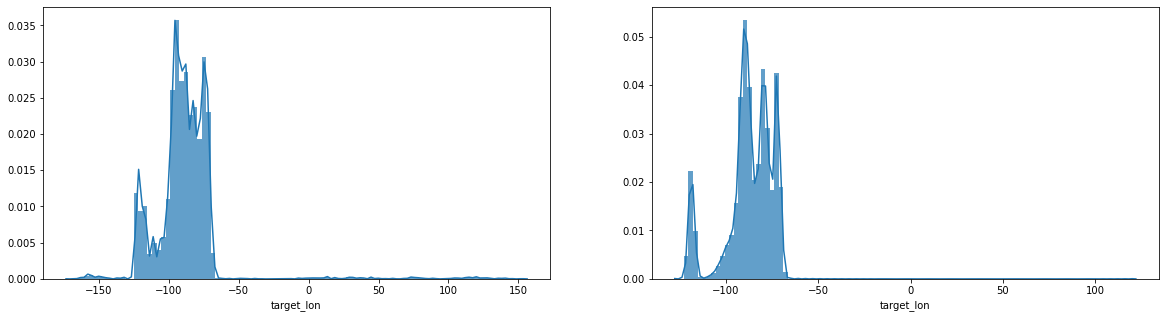

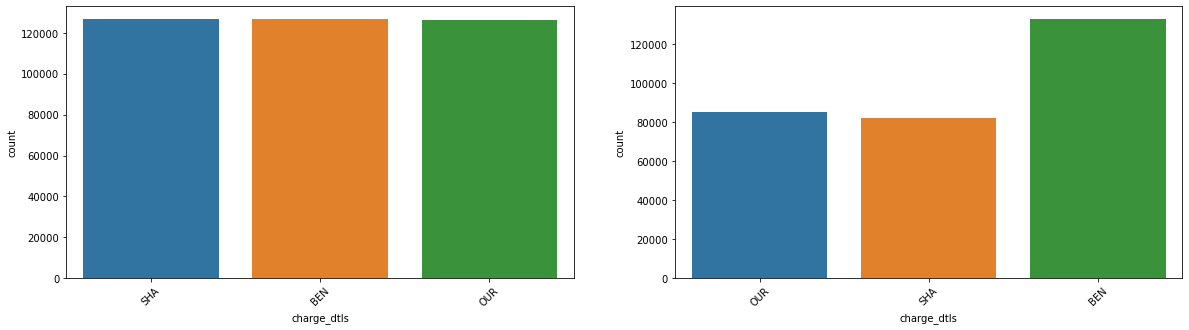

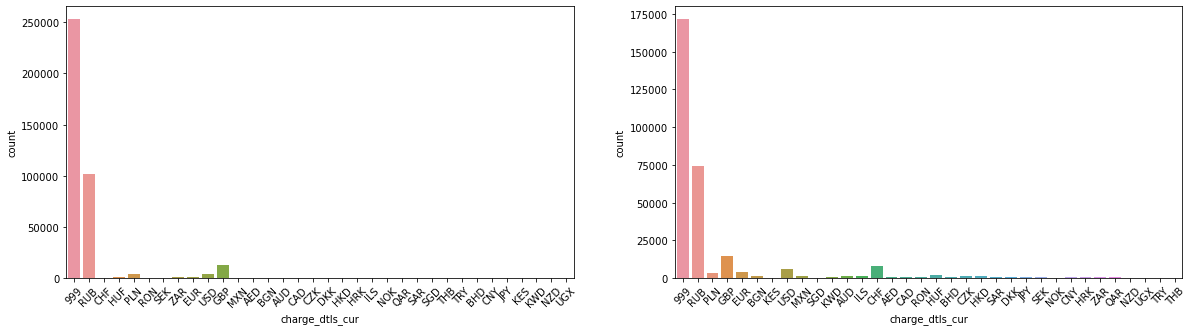

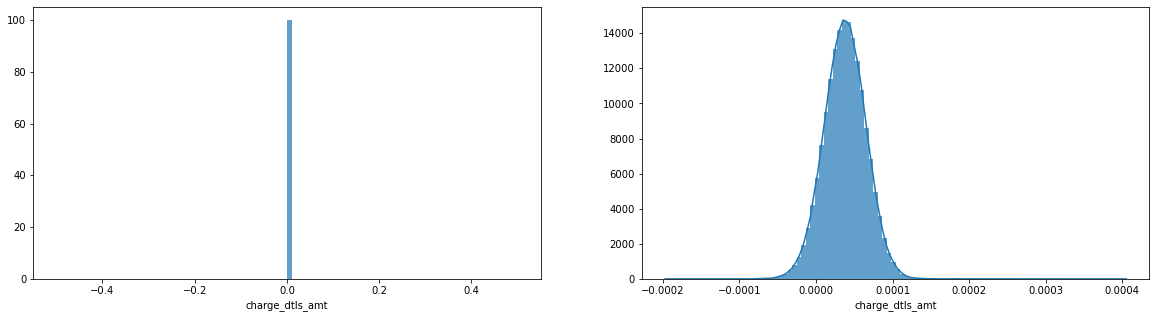

In [27]:
attr_plot(data, samples)

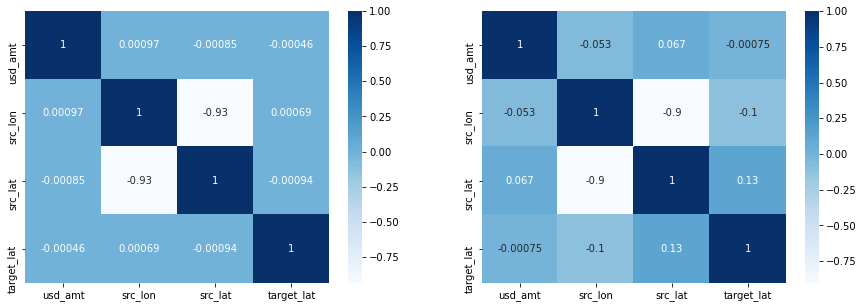

In [29]:
corrplot(data,samples)

In [30]:
# transformer = DataTransformer()

In [65]:
numerical_columns = data._get_numeric_data().columns
discrete_columns = [col for col in data.columns if col not in numerical_columns]

In [62]:
# %%time 
# transformer.fit(data, discrete_columns)

In [63]:
# %%time
# data_ = transformer.transform(data)

In [35]:
data_.shape

(379526, 113)

In [47]:
new_samples = transform.transform(samples)

In [48]:
cov_samples = new_samples.T.dot(new_samples)
Us, ss, Vts = np.linalg.svd(cov_samples)

In [49]:
cov_data = data_.T.dot(data_)
Ud, sd, Vtd = np.linalg.svd(cov_data)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 <a list of 30 Text major ticklabel objects>)

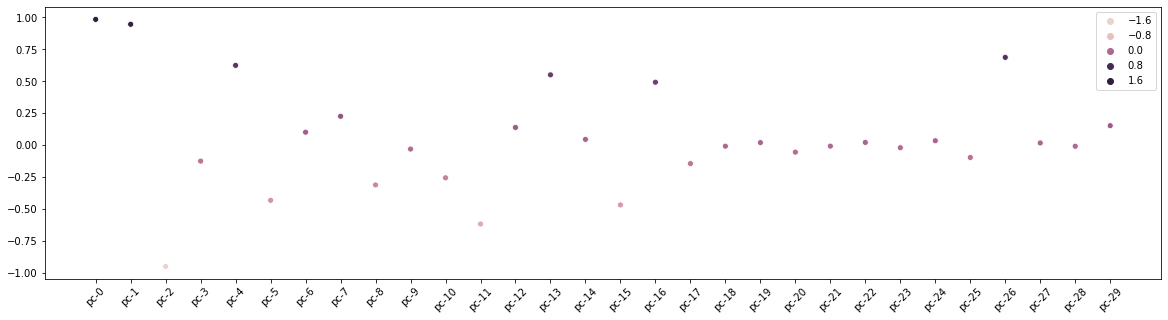

In [53]:
n_components = 30
x = ['pc-'+str(i) for i in range(n_components)]
y = [Us[:, i].dot(Ud[:, i]) for i in range(n_components)]

plt.figure(figsize=(20, 5))
sns.scatterplot(x, y, hue=y)
plt.xticks(rotation=45)
# for i, txt in enumerate(range(10)):
#     plt.annotate(txt, (x[i], y[i]))

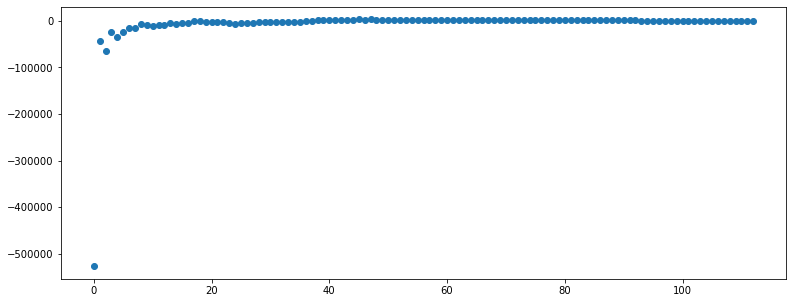

In [51]:
plt.figure(figsize=(13, 5))
plt.scatter(range(Us.shape[1]), ss - sd)

In [70]:
%%time
samples_xfm = transformer.transform(samples)

CPU times: user 1min 13s, sys: 6.08 s, total: 1min 19s
Wall time: 1min 10s


In [71]:
cov_samples = samples_xfm.T.dot(samples_xfm)
Us, ss, Vts = np.linalg.svd(cov_samples)

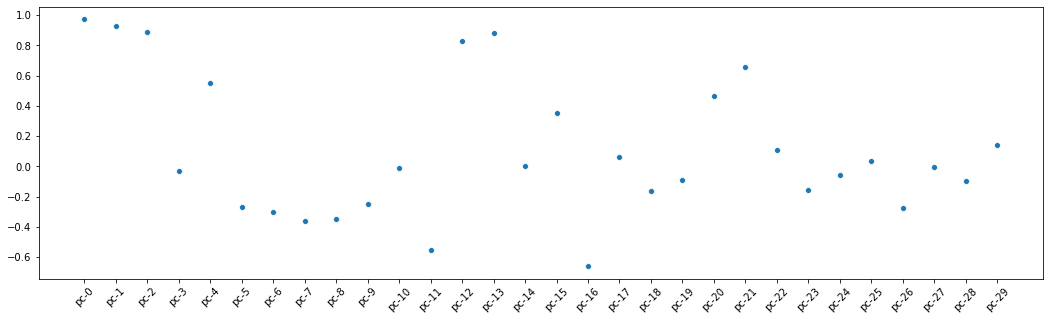

In [76]:
n_components = 30
x = ['pc-'+str(i) for i in range(n_components)]
y = [Us[:, i].dot(Ud[:, i]) for i in range(n_components)]

plt.figure(figsize=(18, 5))
sns.scatterplot(x, y)
plt.xticks(rotation=45)
plt.show()
# for i, txt in enumerate(range(10)):
#     plt.annotate(txt, (x[i], y[i]))

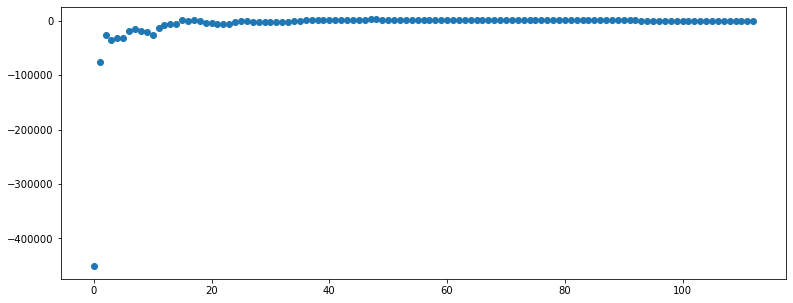

In [77]:
plt.figure(figsize=(13, 5))
plt.scatter(range(Us.shape[1]), ss - sd)
plt.show()

In [80]:
from sklearn.mixture import GaussianMixture as GMM

In [81]:
%%time
gmm = GMM(n_components = 10, covariance_type = "full", random_state = 0).fit(samples_xfm)

CPU times: user 6min 16s, sys: 2min 10s, total: 8min 27s
Wall time: 2min 39s


In [85]:
%%time
samples_labels = gmm.predict(samples_xfm)

CPU times: user 10.1 s, sys: 5.34 s, total: 15.4 s
Wall time: 5.11 s


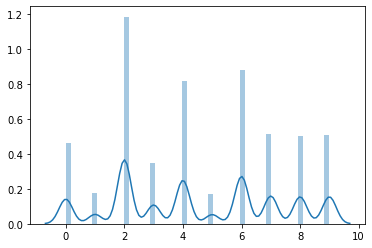

In [94]:
sns.distplot(samples_labels)

In [95]:
%%time
gmm_data = GMM(n_components = 10, covariance_type = "full", random_state = 0).fit(data_)

CPU times: user 11min 51s, sys: 3min 42s, total: 15min 33s
Wall time: 5min 22s


In [193]:
%%time
data_labels = gmm_data.predict(data_)

CPU times: user 12 s, sys: 6.14 s, total: 18.2 s
Wall time: 6.53 s


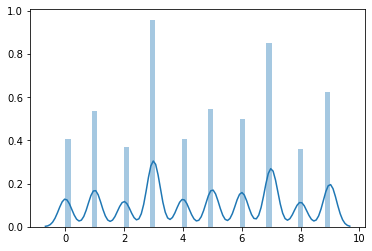

In [194]:
sns.distplot(data_labels)

In [195]:
v_ = pd.DataFrame(data_labels).value_counts()
z_ = np.array([v_.to_dict()[x]/v_.sum() for x in v_.to_dict().keys()])

In [196]:
vs_ = pd.DataFrame(samples_labels).value_counts()
zs_ = np.array([vs_.to_dict()[x]/vs_.sum() for x in vs_.to_dict().keys()])

In [197]:
import scipy
import sklearn

scipy.special.kl_div(z_, zs_).sum()

0.039120440402699797

In [198]:
sklearn.metrics.mutual_info_score(z_, zs_)

2.302585092994046

In [199]:
scipy.stats.entropy(z_, zs_)

0.03912044040269978